In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
from skimage import io, morphology
import napari
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [2]:
path_DAPI='/mnt/sshfs/cp0293/lottep/vizgen/small_Im_DAPI.tiff'
path_polyT='/mnt/sshfs/cp0293/lottep/vizgen/small_Im_polyT.tiff'

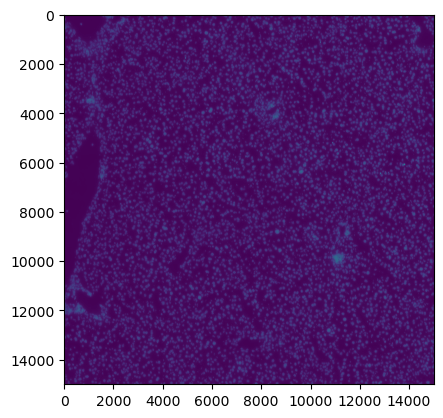

In [3]:
Id=io.imread(path_DAPI)
plt.imshow(Id)

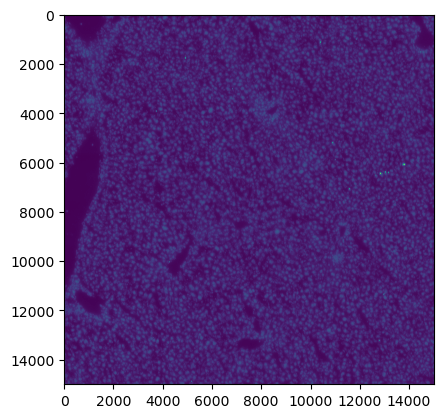

In [4]:
IP=io.imread(path_polyT)
plt.imshow(IP)

In [5]:
import geopandas
path_geopandas='/mnt/sshfs/cp0293/lottep/vizgen/vizgen_Subset_20000.geojson'
geop = geopandas.read_file(path_geopandas,index_col=0)
del geop['index']

In [6]:
path_geopandasP='/mnt/sshfs/cp0293/lottep/vizgen/vizgen_Subset_45000_polyT.geojson'
geopP = geopandas.read_file(path_geopandasP,index_col=0)
del geopP['index']

In [7]:
geopD=geop.cx[0:15000,0:15000]
geopP=geopP.cx[0:15000,0:15000]

In [8]:
coords_for_napariD=[]
for i in geopD.geometry.boundary.explode():
    if i:
        i=i.simplify(tolerance=4)
        coords_for_napariD.append(np.array(i.coords)[:,[1,0]])

/tmp/ipykernel_14114/2124480242.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  for i in geopD.geometry.boundary.explode():


In [9]:
coords_for_napariP=[]
for i in geopP.geometry.boundary.explode():
    if i:
        i=i.simplify(tolerance=4)
        coords_for_napariP.append(np.array(i.coords)[:,[1,0]])

/tmp/ipykernel_14114/3825421035.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  for i in geopP.geometry.boundary.explode():


In [10]:
#viewer = napari.view_image(Id, rgb=False)
viewer = napari.Viewer()
max_contrast_limit = np.max(Id)
# max_contrast_limit = np.iinfo(img.dtype).max
viewer.add_image(Id, contrast_limits=[0, np.max(Id)/2])  
viewer.add_image(IP, contrast_limits=[0, np.max(IP)/2])  

viewer.add_shapes(coords_for_napariD,name='DAPI',shape_type='polygon',face_color='cyan',opacity=0.3,edge_width=3,edge_color='black')
viewer.add_shapes(coords_for_napariP,name='PolyT',shape_type='polygon',face_color='purple',opacity=0.3,edge_width=3,edge_color='black')

<Shapes layer 'PolyT' at 0x7f9570d40dc0>

In [11]:
viewer.layers['PolyT'].face_color = 'red'


In [12]:
voronoi=geopandas.sjoin(geopD,geopP,predicate='intersects',how='left')
Vclean=voronoi.loc[np.isnan(voronoi.index_right)==False,:]
polyT_match=pd.DataFrame(data=None,index=geopD.index)
Vclean['matchedArea']=Vclean.intersection(geopP.loc[Vclean.index_right],align=False).area/Vclean.area
Vclean=Vclean.loc[Vclean.matchedArea>0.2,:]

/tmp/ipykernel_14114/4220147873.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  Vclean['matchedArea']=Vclean.intersection(geopP.loc[Vclean.index_right],align=False).area/Vclean.area
/home/lottep/miniconda3/envs/napari-sparrow/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [13]:
Vclean.index=Vclean.index.rename('index')
temp=Vclean.sort_values('matchedArea', ascending=False).loc[~Vclean.sort_values('matchedArea', ascending=False).index.duplicated(keep='first'),:]
temp.index=temp.index.rename('index')
polyT_match.index=polyT_match.index.rename('index')
polyT_match=polyT_match.merge(temp,how='left',on='index')
polyT_match.drop(columns=['geometry'],inplace=True)

In [14]:
voronoi.index_right

0           27.0
1            0.0
3        72056.0
3           32.0
4            4.0
          ...   
72419      440.0
72470      591.0
72474      594.0
72524    69614.0
72785      313.0
Name: index_right, Length: 21034, dtype: float64

In [15]:
np.sum(np.isnan(voronoi.index_right))

100

In [16]:
Vclean=voronoi.loc[np.isnan(voronoi.index_right)==False,:]

In [17]:
polyT_match=pd.DataFrame(data=None,index=geopD.index)

In [18]:
polyT_match['Cellindex']=np.NaN
polyT_match['Area']=np.NaN

In [19]:
Vclean['matchedArea']=Vclean.intersection(geopP.loc[Vclean.index_right],align=False).area/Vclean.area

/tmp/ipykernel_14114/171707489.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  Vclean['matchedArea']=Vclean.intersection(geopP.loc[Vclean.index_right],align=False).area/Vclean.area
/home/lottep/miniconda3/envs/napari-sparrow/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [128]:
Vclean

,geometry,index_right,matchedArea
0,"POLYGON ((1521.00000 0.00000, 1579.00000 0.000...",27.0,1.000000
1,"MULTIPOLYGON (((7451.00000 8.00000, 7452.00000...",0.0,0.999932
3,"POLYGON ((1281.00000 7415.00000, 1291.00000 74...",72056.0,0.000976
3,"POLYGON ((1281.00000 7415.00000, 1291.00000 74...",32.0,0.999024
4,"POLYGON ((7558.00000 7466.00000, 7565.00000 74...",4.0,1.000000
...,...,...,...
72419,"POLYGON ((11417.00000 7392.00000, 11426.00000 ...",440.0,0.698940
72470,"POLYGON ((12855.00000 7406.00000, 12858.00000 ...",591.0,1.000000
72474,"POLYGON ((13923.00000 14959.00000, 13936.00000...",594.0,0.995986
72524,"POLYGON ((14162.00000 7414.00000, 14165.00000 ...",69614.0,1.000000


In [99]:
Vclean=Vclean.loc[Vclean.matchedArea>0.2,:]

In [130]:
Vclean.index=Vclean.index.rename('index')

In [132]:
Vclean.groupby('index')['matchedArea'].transform(max)

index
0        1.000000
1        0.999932
3        0.999024
3        0.999024
4        1.000000
           ...   
72419    0.698940
72470    1.000000
72474    0.995986
72524    1.000000
72785    1.000000
Name: matchedArea, Length: 20934, dtype: float64

groupby en dan filter

In [ ]:
.index.duplicated(keep='first')

In [155]:
Try2=Vclean.sort_values('matchedArea', ascending=False).loc[~Vclean.sort_values('matchedArea', ascending=False).index.duplicated(keep='first'),:]

In [145]:
Try2.loc[3]

geometry       POLYGON ((1281 7415, 1291 7415, 1291 7416, 129...
index_right                                                 32.0
matchedArea                                             0.999024
Name: 3, dtype: object

In [143]:
Vclean.sort_values('matchedArea', ascending=False)

,geometry,index_right,matchedArea
index,,,
0,"POLYGON ((1521.00000 0.00000, 1579.00000 0.000...",27.0,1.0
36705,"POLYGON ((14238.00000 10792.00000, 14248.00000...",37047.0,1.0
36932,"POLYGON ((1618.00000 3084.00000, 1623.00000 30...",35599.0,1.0
36912,"POLYGON ((7043.00000 11042.00000, 7047.00000 1...",36204.0,1.0
36880,"POLYGON ((7365.00000 3078.00000, 7367.00000 30...",35287.0,1.0
...,...,...,...
50343,"POLYGON ((13004.00000 4705.00000, 13015.00000 ...",49093.0,0.0
10731,"POLYGON ((2411.00000 8464.00000, 2421.00000 84...",10025.0,0.0
30566,"POLYGON ((6887.00000 10419.00000, 6894.00000 1...",29812.0,0.0


In [159]:
np.sum(Try2.matchedArea>0.2)

10686

In [157]:
np.sum(Vclean.matchedArea>0.51)

10482

In [158]:
geopD

,geometry
0,"POLYGON ((1521.00000 0.00000, 1579.00000 0.000..."
1,"MULTIPOLYGON (((7451.00000 8.00000, 7452.00000..."
3,"POLYGON ((1281.00000 7415.00000, 1291.00000 74..."
4,"POLYGON ((7558.00000 7466.00000, 7565.00000 74..."
5,"MULTIPOLYGON (((15062.00000 7471.00000, 15062...."
...,...
72419,"POLYGON ((11417.00000 7392.00000, 11426.00000 ..."
72470,"POLYGON ((12855.00000 7406.00000, 12858.00000 ..."
72474,"POLYGON ((13923.00000 14959.00000, 13936.00000..."
72524,"POLYGON ((14162.00000 7414.00000, 14165.00000 ..."


In [179]:
Try2.matchedArea.values

array([1., 1., 1., ..., 0., 0., 0.])

In [166]:
polyT_match.index

Int64Index([    0,     1,     3,     4,     5,     9,    10,    22,    23,
               25,
            ...
            72353, 72364, 72378, 72381, 72392, 72419, 72470, 72474, 72524,
            72785],
           dtype='int64', length=10969)

In [176]:
polyT_match.loc[Try2.index,:]['Area']=Try2.matchedArea.values

In [175]:
polyT_match.loc[Try2.index,:]['Area']lottepollaris@gmail.com

index
0       NaN
36705   NaN
36932   NaN
36912   NaN
36880   NaN
         ..
25043   NaN
31722   NaN
68802   NaN
10844   NaN
62581   NaN
Name: Area, Length: 10869, dtype: float64

In [181]:
Try2.index=Try2.index.rename('index')

In [186]:
Try2.index=Try2.index.rename('index')
polyT_match.index=polyT_match.index.rename('index')
polyT_match.merge(Try2,how='left',on='index')

In [187]:
polyT_match.merge(Try2,how='left',on='index')

,Cellindex,Area,geometry,index_right,matchedArea
index,,,,,
0,NaN,NaN,"POLYGON ((1521.00000 0.00000, 1579.00000 0.000...",27.0,1.000000
1,NaN,NaN,"MULTIPOLYGON (((7451.00000 8.00000, 7452.00000...",0.0,0.999932
3,NaN,NaN,"POLYGON ((1281.00000 7415.00000, 1291.00000 74...",32.0,0.999024
4,NaN,NaN,"POLYGON ((7558.00000 7466.00000, 7565.00000 74...",4.0,1.000000
5,NaN,NaN,"MULTIPOLYGON (((15062.00000 7471.00000, 15062....",5.0,1.000000
...,...,...,...,...,...
72419,NaN,NaN,"POLYGON ((11417.00000 7392.00000, 11426.00000 ...",440.0,0.698940
72470,NaN,NaN,"POLYGON ((12855.00000 7406.00000, 12858.00000 ...",591.0,1.000000
72474,NaN,NaN,"POLYGON ((13923.00000 14959.00000, 13936.00000...",594.0,0.995986


In [188]:
Try2

,geometry,index_right,matchedArea
index,,,
0,"POLYGON ((1521.00000 0.00000, 1579.00000 0.000...",27.0,1.0
36705,"POLYGON ((14238.00000 10792.00000, 14248.00000...",37047.0,1.0
36932,"POLYGON ((1618.00000 3084.00000, 1623.00000 30...",35599.0,1.0
36912,"POLYGON ((7043.00000 11042.00000, 7047.00000 1...",36204.0,1.0
36880,"POLYGON ((7365.00000 3078.00000, 7367.00000 30...",35287.0,1.0
...,...,...,...
25043,"POLYGON ((12680.00000 9717.00000, 12685.00000 ...",25209.0,0.0
31722,"POLYGON ((5315.00000 2645.00000, 5322.00000 26...",29020.0,0.0
68802,"POLYGON ((5124.00000 6853.00000, 5125.00000 68...",69629.0,0.0
